## Kaggle competition: Automated Essay Scoring 2.0

### Libraries loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

import nltk
nltk.download('wordnet')

import nltk
nltk.download('punkt')

C:\Users\LiangX\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# load the first 10M rows of data
train_data = pd.read_csv('.\\learning-agency-lab-automated-essay-scoring-2\\train.csv')
train_data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [4]:
# sampling some essay to see how large is the length 
len(train_data.iloc[1500, 1])  

1612

### Game plan:
    1. clean up all the data
    2. topic modeling
    3. try to evaluate all dimensions data for analysing how did the essay Demonstrates Mastery
    4. using all generated dimensions to predict scores

### Cleaning data

In [5]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [6]:
train_data['full_text'] = train_data['full_text'].apply(lambda x:clean_text(x))
train_data.head(10)

,essay_id,full_text,score
0,000d118,many people have car where they live the thing...,3
1,000fe60,i am a scientist at nasa that is discussing th...,3
2,001ab80,people always wish they had the same technolog...,4
3,001bdc0,we all heard about venus the planet without al...,4
4,002ba53,dear state senatorthis is a letter to argue in...,3
5,0030e86,if i were to choose between keeping the electo...,4
6,0033037,the posibilty of a face reconizing computer wo...,2
7,0033bf4,what is the seagoing cowboys progamit was to h...,3
8,0036253,the challenge of exploring venusthis storie is...,2
9,0040e27,there are many reasons why you should join sea...,3


In [7]:
def remove_stopword(text):
    if pd.notnull(text):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_text)
    return text

In [8]:
train_data['full_text'] = train_data['full_text'].apply(lambda x:remove_stopword(x))
train_data.head(10)

,essay_id,full_text,score
0,000d118,many people car live thing dont know use car a...,3
1,000fe60,scientist nasa discussing face mars explaining...,3
2,001ab80,people always wish technology seen movies best...,4
3,001bdc0,heard venus planet without almost oxygen earth...,4
4,002ba53,dear state senatorthis letter argue favor keep...,3
5,0030e86,choose keeping electoral college abolishing wo...,4
6,0033037,posibilty face reconizing computer would helpf...,2
7,0033bf4,seagoing cowboys progamit help many countries ...,3
8,0036253,challenge exploring venusthis storie challeng ...,2
9,0040e27,many reasons join seagoing cowboys program wou...,3


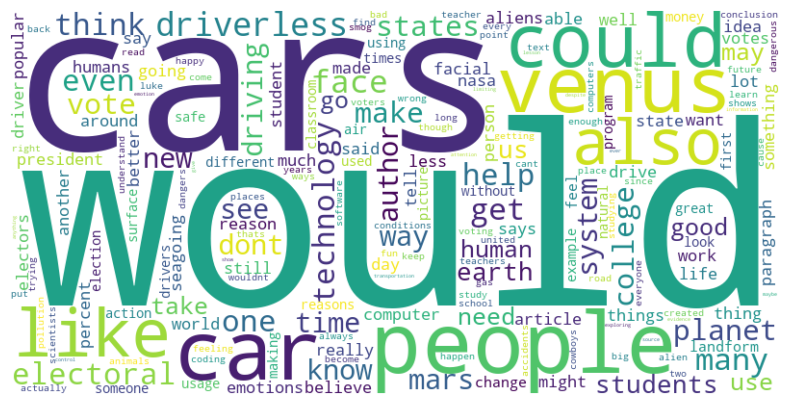

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with columns 'url' and 'text'

# Tokenize the text
tokens = word_tokenize(' '.join(train_data['full_text']))

# Count the occurrence of each word
word_counts = pd.Series(tokens).value_counts()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Topic modeling

#### Latent Dirichlet Allocation (LDA): 
This is the most widely used method for topic modeling. LDA works by assuming that each document is a mixture of several topics, and each topic is a probability distribution over words. The algorithm then tries to find the hidden topics that best explain the observed documents. LDA is a powerful method that can be used to uncover complex thematic structures in large collections of text data.

In [10]:
import gensim
# for LDA
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# for LDA evaluation
import pip 
import pyLDAvis.gensim_models as gensimvisualize

from sklearn.feature_extraction.text import CountVectorizer

In [11]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# def remove_stopwords(texts):
    # return [[word for word in simple_preprocess(str(doc)) 
             # if word not in stop_words] for doc in texts]

data = train_data.full_text.values.tolist()
data_words = list(sent_to_words(data))# remove stop words

# data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lxf12\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['many', 'people', 'car', 'live', 'thing', 'dont', 'know', 'use', 'car', 'alot', 'thing', 'happen', 'like', 'get', 'accidet', 'smoke', 'car', 'bad', 'breath', 'someone', 'walk', 'vaubangermany', 'dont', 'proble', 'percent', 'vaubans', 'families', 'carsand', 'percent', 'sold']


In [12]:
import gensim.corpora as corpora# Create Dictionary

id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words   # Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 14), (23, 3), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [13]:
# from pprint import pprint

# # number of topics
# num_topics = 8     

# # Build LDA model
# lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=num_topics)# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [14]:
# # Train the LDA model
# num_topics = 8
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=20, alpha='auto', eta='auto')

# # Get the topics
# topics = ldamodel.show_topics(num_topics=num_topics, num_words=10, log=False, formatted=False)

# # Print the topics
# for topic_id, topic in topics:
#     print("Topic: {}".format(topic_id))
#     print("Words: {}".format([word for word, _ in topic]))

#### Tuning LDA modeling

In [15]:
# def calculate_coherence_score(n, alpha, beta):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=n, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=alpha,
#                                            per_word_topics=True,
#                                            eta = beta)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v', processes=1)
#     coherence_lda = coherence_model_lda.get_coherence()
#     return coherence_lda

# #list containing various hyperparameters
# no_of_topics = [8, 12, 18]
# alpha_list = ['symmetric',0.3,0.5,0.7]
# beta_list = ['auto',0.3,0.5,0.7]


# for n in no_of_topics:
#     for alpha in alpha_list:
#         for beta in beta_list:
#             coherence_score = calculate_coherence_score(n, alpha, beta)
#             print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")


'''
This for loop takes a few hours to run
so here is the result: and we don't want to run this again:
'''
'''
n : 8 ; alpha : symmetric ; beta : auto ; Score : 0.5867571344360871
n : 8 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6484286193478872
n : 8 ; alpha : symmetric ; beta : 0.5 ; Score : 0.6908468584411063
n : 8 ; alpha : symmetric ; beta : 0.7 ; Score : 0.6535039626900472
n : 8 ; alpha : 0.3 ; beta : auto ; Score : 0.7009901825318623
n : 8 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.6067786338573026
n : 8 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6884324910768638
n : 8 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6159885331868643
n : 8 ; alpha : 0.5 ; beta : auto ; Score : 0.5892287024171865
n : 8 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.6001228872778723
n : 8 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.6771281385904965
n : 8 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.6308784067976919
n : 8 ; alpha : 0.7 ; beta : auto ; Score : 0.5896615094033433
n : 8 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.5892956339922097
n : 8 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.6489195742346713
n : 8 ; alpha : 0.7 ; beta : 0.7 ; Score : 0.6444760144697218
n : 12 ; alpha : symmetric ; beta : auto ; Score : 0.5750300760673676
n : 12 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6849110437993057
n : 12 ; alpha : symmetric ; beta : 0.5 ; Score : 0.7314194212807755
n : 12 ; alpha : symmetric ; beta : 0.7 ; Score : 0.76320512140851
n : 12 ; alpha : 0.3 ; beta : auto ; Score : 0.6213726949189714
n : 12 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.5161033312814763
n : 12 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6272328248043099
n : 12 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6730741674189091
n : 12 ; alpha : 0.5 ; beta : auto ; Score : 0.6077342896100025
n : 12 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.5935212555277873
n : 12 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.540065264714628
n : 12 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.5469721196213261
n : 12 ; alpha : 0.7 ; beta : auto ; Score : 0.6230499220866276
n : 12 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.6643458580320608
n : 12 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.53247498510502
n : 12 ; alpha : 0.7 ; beta : 0.7 ; Score : 0.5513126167860697
n : 18 ; alpha : symmetric ; beta : auto ; Score : 0.5684524380785312
n : 18 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6339300188517728
n : 18 ; alpha : symmetric ; beta : 0.5 ; Score : 0.6830333628690716
n : 18 ; alpha : symmetric ; beta : 0.7 ; Score : 0.70750756576385
n : 18 ; alpha : 0.3 ; beta : auto ; Score : 0.5432114628137467
n : 18 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.5291213920783898
n : 18 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.5770419998172478
n : 18 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.5950913864671474
n : 18 ; alpha : 0.5 ; beta : auto ; Score : 0.5853262650331381
n : 18 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.4610565717199081
n : 18 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.5082908394269366
n : 18 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.497395366148738
n : 18 ; alpha : 0.7 ; beta : auto ; Score : 0.5336068890678578
n : 18 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.4891766592065441
n : 18 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.5062269165521386
n : 18 ; alpha : 0.7 ; beta : 0.7 ; Score : 0.5478582738764528
'''

'\nn : 8 ; alpha : symmetric ; beta : auto ; Score : 0.5867571344360871\nn : 8 ; alpha : symmetric ; beta : 0.3 ; Score : 0.6484286193478872\nn : 8 ; alpha : symmetric ; beta : 0.5 ; Score : 0.6908468584411063\nn : 8 ; alpha : symmetric ; beta : 0.7 ; Score : 0.6535039626900472\nn : 8 ; alpha : 0.3 ; beta : auto ; Score : 0.7009901825318623\nn : 8 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.6067786338573026\nn : 8 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.6884324910768638\nn : 8 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6159885331868643\nn : 8 ; alpha : 0.5 ; beta : auto ; Score : 0.5892287024171865\nn : 8 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.6001228872778723\nn : 8 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.6771281385904965\nn : 8 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.6308784067976919\nn : 8 ; alpha : 0.7 ; beta : auto ; Score : 0.5896615094033433\nn : 8 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.5892956339922097\nn : 8 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.6489195742346713\nn : 8 ; alpha : 0.7 ; be

In [16]:
# Train the LDA model
num_topics = 12
# ldamodel = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=20, alpha='symmetric', eta=0.7)
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.7)

# Get the topics
topics = ldamodel.show_topics(num_topics=num_topics, num_words=20, log=False, formatted=False)

# Print the topics
for topic_id, topic in topics:
    print("Topic: {}".format(topic_id))
    print("Words: {}".format([word for word, _ in topic]))

Topic: 0
Words: ['seagoing', 'luke', 'animals', 'cowboy', 'cowboys', 'program', 'join', 'help', 'fun', 'also', 'places', 'get', 'helping', 'see', 'trips', 'world', 'go', 'war', 'time', 'countries']
Topic: 1
Words: ['electoral', 'vote', 'college', 'president', 'states', 'electors', 'votes', 'popular', 'state', 'election', 'voting', 'voters', 'system', 'people', 'candidate', 'unfair', 'candidates', 'united', 'process', 'presidential']
Topic: 2
Words: ['cars', 'car', 'usage', 'driving', 'pollution', 'air', 'people', 'less', 'smog', 'day', 'paris', 'limiting', 'transportation', 'percent', 'city', 'use', 'world', 'gas', 'without', 'source']
Topic: 3
Words: ['planit', 'increse', 'obstcals', 'cautching', 'peoplewithout', 'conceptyou', 'oporator', 'anyoneso', 'advaratisers', 'ocasionalyso', 'marketwhile', 'advacates', 'loath', 'innificent', 'getat', 'driveingbut', 'crossproductive', 'okayevery', 'adveratiseing', 'transportedbut']
Topic: 4
Words: ['venus', 'planet', 'author', 'earth', 'dangers'

##### cars, space, animals, politics, technology topics

### Judgement on the essay mastery: 
    1. a point of view on the issue
    2. critical thinking
    3. appropriate examples, reasons, and other evidence
    4. clear coherence and smooth progression
### Jugement on language mastery: (will use feedback data model to help)
    cohesion, syntax, vocabulary, phraseology, grammar, conventions

#### critical thinking

In [20]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...


True

In [22]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### What is critical thinking?
Critical thinking is the ability to interpret, evaluate, and analyze facts and information that are available, to form a judgment or decide if something is right or wrong.

In [26]:
def analyze_text_structure(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    num_questions = sum(1 for sentence in sentences if sentence.endswith('?'))
    
    return {
        'num_sentences': len(sentences),
        'num_words': len(filtered_words),
        'num_questions': num_questions
    }

def evaluate_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return {
        'polarity': sentiment.polarity,
        'subjectivity': sentiment.subjectivity
    }

def check_argumentation(text):
    sentences = sent_tokenize(text)
    argument_words = ['because', 'therefore', 'hence', 'thus', 'consequently', 'as a result', 'due to', 'since', 'so', 'leads to', 
        'results in', 'however', 'although', 'though', 'but', 'on the other hand', 'whereas', 'yet', 'despite', 
        'in contrast', 'nevertheless', 'nonetheless', 'in conclusion', 'to sum up', 'finally', 'in summary', 
        'for example', 'for instance', 'such as', 'including', 'like', 'particularly', 'in particular', 
        'to illustrate', 'as an example', 'furthermore', 'moreover', 'additionally', 'besides', 'also', 
        'in addition', 'plus', 'along with', 'if', 'unless', 'provided that', 'assuming that', 'even if', 
        'only if', 'given that', 'as long as', 'in case', 'since', 'for', 'as', 'in other words', 'that is', 
        'to clarify', 'to explain', 'namely', 'indeed', 'in fact', 'certainly', 'surely', 'of course', 'notably', 
        'significantly', 'especially', 'importantly', 'then', 'next', 'afterwards', 'later', 'subsequently', 
        'previously', 'before', 'after', 'eventually', 'meanwhile']
    arguments = [sentence for sentence in sentences if any(word in sentence.lower() for word in argument_words)]
    return len(arguments)

def count_numbers(text):
    numbers = re.findall(r'\b\d+(\.\d+)?\b', text)
    return len(numbers)

def count_personal_opinions(text):
    opinion_words = ['I think', 'I believe', 'I feel', 'I guess', 'I hope', 'I doubt', 'I assume', 'I imagine', 
        'I suppose', 'I wonder', 'I predict', 'I suspect', 'I prefer', 'I’d say', 'I’m sure', 'I suggest', 
        'I propose', 'I fear', 'I reckon', 'Personally', 'In my view', 'My view', 'It seems', 'It appears', 
        'I bet', 'I’d argue', 'I’d think', 'I’d hope', 'My guess', 'To me', 'For me', 'My take', 'I believe that', 
        'I think that', 'I feel that', 'I hope that', 'I doubt that', 'I imagine that', 'I suppose that', 
        'I guess that', 'I assume that', 'I suspect that', 'I’d say that', 'I’d argue that', 'I’d think that', 
        'I’d hope that', 'It seems that', 'It appears that', 'My guess is that', 'My view is that']
    sentences = sent_tokenize(text)
    opinions = [sentence for sentence in sentences if any(phrase in sentence for phrase in opinion_words)]
    return len(opinions)

def critical_thinking_analysis(text):
    structure_analysis = analyze_text_structure(text)
    sentiment_analysis = evaluate_sentiment(text)
    argumentation_count = check_argumentation(text)
    number_count = count_numbers(text)
    opinion_count = count_personal_opinions(text)

    critical_thinking_score = 0
    
    # Increase score based on the presence of critical thinking indicators
    if structure_analysis['num_sentences'] > 10:
        critical_thinking_score += 1
    #     print("sentences number is high")
    if structure_analysis['num_words'] > 250:
        critical_thinking_score += 1
        # print("words number is high")
    if structure_analysis['num_questions'] > 1:
        critical_thinking_score += 1
        # print("throw questions")
    if abs(sentiment_analysis['polarity']) < 0.5:  # Neutral to balanced sentiment
        critical_thinking_score += 1
        # print("balanced sentiment")
    if argumentation_count > 3:
        critical_thinking_score += 1
        # print("arguments enough")
    if number_count > 5:  # Adjust threshold as needed
        critical_thinking_score += 1
        # print("used numbers")
    if opinion_count > 1:  # Penalize for too many personal opinions
        critical_thinking_score -= 1
        # print("too much opinions")

    return critical_thinking_score

# Example usage
text = """
Climate change is a pressing issue that affects everyone. It is caused by human activities, particularly the burning of fossil fuels.
However, there are differing opinions on how to address it. Some argue that renewable energy is the solution, because it reduces carbon emissions.
Therefore, investing in renewable energy is essential. For instance, wind energy production increased by 25% in 2020 and solar energy saw a 15% rise.
But, others believe that economic growth should not be sacrificed. The GDP grew by 3% last year despite these changes.
What is the best approach? We need to balance environmental sustainability with economic development. Personally, I think renewable energy is the best solution.
"""

score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")


Critical Thinking Score: 3


In [50]:
text = "There are many reasons why you should join seagoing cowboys program. You would be helping your country. You'd be traveling around the world. Last you'd have lots of fun over seas. You'd be helping our country because when Luke was in seagoing cowboy program it was 1945 and world war 2 was happening in Europe and he had to those countries recover. Luke had to help the horses when the war was over to get people places and to work. If you were 18 or up you might be lucky and be drafted into the military service. The UNRRA would hire seagoing Cowboys to feed the horses cows and mules that were shipped overseas. You'd be traveling around they world like Luke did. It took Luke 2 weeks to cross the Atlantic Ocean from the eastern coast. You'd be traveling to China, Europe, Greece, and many more places. The only way you'd be good at this job is if you wouldn't get sea sick because if you are a seagoing cowboy told travel overseas a lot. You'd have fun overseas if you don't get seasick. You'd have many adventures. You'd have many stories to tell your friends and family. You'd been in countries you'd didn't think you'd be in. You'd be able to play games in the countries you visit in the seagoing Cowboys program. If you join the seagoing Cowboys program you'd love it. You'd be traveling. You'd be having fun. You'd be helping our country. So why don't you join our seagoing cowboy program. I bet you'd love to be in this program with all our helpful friends and family that want to try to help our country. "
print(text)
print('\n')

score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")

There are many reasons why you should join seagoing cowboys program. You would be helping your country. You'd be traveling around the world. Last you'd have lots of fun over seas. You'd be helping our country because when Luke was in seagoing cowboy program it was 1945 and world war 2 was happening in Europe and he had to those countries recover. Luke had to help the horses when the war was over to get people places and to work. If you were 18 or up you might be lucky and be drafted into the military service. The UNRRA would hire seagoing Cowboys to feed the horses cows and mules that were shipped overseas. You'd be traveling around they world like Luke did. It took Luke 2 weeks to cross the Atlantic Ocean from the eastern coast. You'd be traveling to China, Europe, Greece, and many more places. The only way you'd be good at this job is if you wouldn't get sea sick because if you are a seagoing cowboy told travel overseas a lot. You'd have fun overseas if you don't get seasick. You'd h

In [21]:
text = "Dear State Senate, I feel that the way we, the people, vote today is very unfair. We should change the voting to popular vote for the president of the United States. The majority of people don't care about voting for the next United States prsident because they don't get to chose who will win. The people that get to vote for one's state might not think about what what the remaining others would want. In source one, this section tells the reader what an electoral college is and how it works. Paragraph two sums up what this system is, ""The Electoral College process consists of the selection of the electors, the meeting of the electors where they vote for president and vice president, and the counting if the electoral votes by Congress."" Basically what this paragraph was saying is that the people dont get to directly say who they want as president. The people of a state get to vote for who they want, but it is ultimately up to the state electors on who will get the vote from that particular state. There could be a ton of people voting for one president, and then there might be less votes for a president who may be even better. Ultimately what this system comes down to is the people don't vote for their next president. They are selecting a name that might not do anything to their country. Source two talks about the electoral college and how the best-laid defenses of the system are wrong. In paragraph nine,  the text says, ""... according to a Gallup poll in 2000, taken shortly after Al Gore- thanks to the quirks of the electoral college- won the popular vote but lost presidency, over 60 percent of voters  would prefer a direct election to the kind we have now."" The electoral college is responsible for picking electors, who can go behind the peoples back and chose the president nobody wanted. This system or process is a total disaster. Paragraph thirteen states, ""At the most basic level, the electoral college is unfair to voters. Because of the winner-take-all system in each state, candidates don't spend time in states they know they have no chance of winning, focusing only on the tight races in the 'swing' states. Paragrapgh twenty-three, ""It can be argued that the electoral college method of selecting the president may turn off potential voters for a candidate who has no hope of carrying their state- Democrates in Texas, for example, or Republicans in California."" If these people were to vote by the system we have now, their vote would have no effect. This leads to the people living in these states to not vote. They don't even pay attention to the campaign anymore. They know that they won't do anything to the votes or who will become president. They couldn't care less. We should get rid of the electoral college all together. This system is not working for a lot of people and this is why many people dont care enough to vote anymore. There are people that vote for our state. Why should the people care? If we switched to popular vote, our country might participate in picking who the next president of the United States will be. When people have a voice, they will use it as much as they possibly can.                             "

print(text)
print('\n')

score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")

Dear State Senate, I feel that the way we, the people, vote today is very unfair. We should change the voting to popular vote for the president of the United States. The majority of people don't care about voting for the next United States prsident because they don't get to chose who will win. The people that get to vote for one's state might not think about what what the remaining others would want. In source one, this section tells the reader what an electoral college is and how it works. Paragraph two sums up what this system is, The Electoral College process consists of the selection of the electors, the meeting of the electors where they vote for president and vice president, and the counting if the electoral votes by Congress. Basically what this paragraph was saying is that the people dont get to directly say who they want as president. The people of a state get to vote for who they want, but it is ultimately up to the state electors on who will get the vote from that particular

In [52]:
text = "Luke was going to China, because his friend asked him and he said he couldn't pass this up. In the text it says that Luke had no idea that his life would change once he graduated high school. He was working two part time jobs. He knew it was an opportunity of a lifetime. the United Nations Relief and rehabiliation Administartion hired ""Seagoing Cowboys"" to take care of the horses, young cows, and the Mule that were shipped overseas. Luke and Don helped and signed up for it. Luke turned 18 before arriving in Greece. When he finally got there he helped on his Aunt Katie's farm. He went on a second trip. The cowboys all got along and began playing table tennis tournaments, baseball,volleyball games, and boxing and the games helped pass some time for the cowboys. The cowboy, also known as Luke Bomberger, lead his family to host a number of international students and exchanged visitors for many years. They arrivred in China August 14, the day the Pacific war ended. I bet his family was very proud of him. When he turned 18 I bet he was excited because he could be drafted for miltary service. Then when his board learned that he was on a cattle boat trip they told him to just keep doing that for service. The reason you should join the Military is because you could save a life. Several of lives. Also because we probably need more people because we could always use more people to protect us. Luke made nine trips after 1947.    "

print(text)
print('\n')

score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")

Luke was going to China, because his friend asked him and he said he couldn't pass this up. In the text it says that Luke had no idea that his life would change once he graduated high school. He was working two part time jobs. He knew it was an opportunity of a lifetime. the United Nations Relief and rehabiliation Administartion hired Seagoing Cowboys to take care of the horses, young cows, and the Mule that were shipped overseas. Luke and Don helped and signed up for it. Luke turned 18 before arriving in Greece. When he finally got there he helped on his Aunt Katie's farm. He went on a second trip. The cowboys all got along and began playing table tennis tournaments, baseball,volleyball games, and boxing and the games helped pass some time for the cowboys. The cowboy, also known as Luke Bomberger, lead his family to host a number of international students and exchanged visitors for many years. They arrivred in China August 14, the day the Pacific war ended. I bet his family was very p

In [23]:
text = "Dear State senator , You should keep the electoral college , beacuse For one theres alot of electors like around 538. A majority of 270 electoral votes is required to elect the president. Then after the presidental election , your governor prepares a 'Certificate of Ascertainment ' listing all of the candidates who ran for president in your state along with the names of their respective electors.To begin with under the 23rd amendment of the constitution ,""The District of Columbia is allocated 3 electors and treated like a state for purposes of the electoral college"" and for that saying , in the  following discussion , the  word state also refers to the district of columbia. Also Each and every candidate that is running for president in your state has his or her own group of electors.""The electors are generally chosen by the candidate's political party , but state laws vary on how the electors are selected and what their responsibilities are.""Foremost , under the electoral college system , voters vote not for the persident , but for a slate of electors , who in turn elect the president.""Who are the electors? They can be anyone not holding public office. Who picks the electors in the  first place? it depends on the state. Now i understand sometimes at state conventions , Partys , central committee , sometimes the presidental candidates themselves , Also sometimes get confused about the electors and vote for the wrong candidate.""The single best argument against the electoral college is what we might call the electoral college is what we might call the  disaster factor. Its Basically whenever theres a  really good argument thats what its called.Subconstantquintly , Sometimes most people worry about the prospect of a tie in the elections vote. ""In That case , the election would be thrown to the house of representatives , where state delegations vote on the president."" At the most basic level , the electoral college is unfair to voters. ""because of the winner-take-all system in each state , candidates dont spend time in states they know they have no chance of winning , focusing only on the tight races in the ""swing"" states. Then now its official "" The electoral college is unfair , outdated , and irrational."" The best arguments in favor of it in favor of it are mostly assertions without much basis in reality.To end with , Thats why you should keep the electoral college because ,  You should keep the electoral college , beacuse For one theres alot of electors like around 538. A majority of 270 electoral votes is required to elect the president. Then after the presidental election , your governor prepares a 'Certificate of Ascertainment ' listing all of the candidates who ran for president in your state along with the names of their respective electors.                    "

print(text)
print('\n')

score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")

Dear State senator , You should keep the electoral college , beacuse For one theres alot of electors like around 538. A majority of 270 electoral votes is required to elect the president. Then after the presidental election , your governor prepares a 'Certificate of Ascertainment ' listing all of the candidates who ran for president in your state along with the names of their respective electors.To begin with under the 23rd amendment of the constitution ,The District of Columbia is allocated 3 electors and treated like a state for purposes of the electoral college and for that saying , in the  following discussion , the  word state also refers to the district of columbia. Also Each and every candidate that is running for president in your state has his or her own group of electors.The electors are generally chosen by the candidate's political party , but state laws vary on how the electors are selected and what their responsibilities are.Foremost , under the electoral college system , 

In [54]:
text = "the colleg now has votes for vice presidant and there are 538 electors but 270 electors are what we are suppos to have 3 were picked by the state they have a presadent election for evry for years if you run for president you get your own group and you get alot of responsibilities and it is held evry tuseday and first monday and the winner takes it all and they have other cannidates to worrie about and the govener prepares for the presidans election and there are about 60% of voters if your the presidant you need to defened your titel back in 1960's in lousiana we almost succeeded but then they hired other electors to go agianst John F Kennedy and then evrybody was faithlessand now their are 500,000 voters and it has increased drasticly and we half to make a congress if your presidant 35,000,000 go to just pick a presidant 41,971 are in deadlock  in 1976 there were about 5,559 elections back then there are 25,000 media markets texas hade the most voters in 1987 and all of are presadents have at least 2,000 or more canadates bush hade the least votes sence 1888 61.5% of votes was compared to a voteing persentage of 51.3% and that was in the north and south 2012 they have boosted their companie and their attinstion by ads and some build boards 29 elctoral votes 3 were passed through their were 301 votes now there are 370 votes and this all happened in 1992 and there are more dimacrats in texas than there are in florida there are 20 in florida and 33 in texas and all of the elections are nation wide and voters do half of the work for just voteing and the pepole are going through the votes to see hew there new presidant is for the new year and all the votes came from Electrol colleg and all of the campains are in the small states and in texas they have turned off votes in texas and now there is less attenstion in the compainey and they do politicl votes and the pepole think that the voters should be the ones to decid the election and up state voters pay close attention to see hew wins."

print(text)
print('\n')

score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")

the colleg now has votes for vice presidant and there are 538 electors but 270 electors are what we are suppos to have 3 were picked by the state they have a presadent election for evry for years if you run for president you get your own group and you get alot of responsibilities and it is held evry tuseday and first monday and the winner takes it all and they have other cannidates to worrie about and the govener prepares for the presidans election and there are about 60% of voters if your the presidant you need to defened your titel back in 1960's in lousiana we almost succeeded but then they hired other electors to go agianst John F Kennedy and then evrybody was faithlessand now their are 500,000 voters and it has increased drasticly and we half to make a congress if your presidant 35,000,000 go to just pick a presidant 41,971 are in deadlock  in 1976 there were about 5,559 elections back then there are 25,000 media markets texas hade the most voters in 1987 and all of are presadents

In [25]:
score = critical_thinking_analysis(text)
print(f"Critical Thinking Score: {score}")

balanced sentiment
used numbers
Critical Thinking Score: 2


##### Generate a new column to store it

In [27]:
train_data = pd.read_csv('.\\learning-agency-lab-automated-essay-scoring-2\\train.csv')
train_data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [28]:
train_data['critical'] = train_data['full_text'].apply(lambda x:critical_thinking_analysis(x))
train_data.head(10)

,essay_id,full_text,score,critical
0,000d118,Many people have car where they live. The thin...,3,5
1,000fe60,I am a scientist at NASA that is discussing th...,3,4
2,001ab80,People always wish they had the same technolog...,4,4
3,001bdc0,"We all heard about Venus, the planet without a...",4,5
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,3
5,0030e86,If I were to choose between keeping the electo...,4,2
6,0033037,The posibilty of a face reconizing computer wo...,2,1
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,4
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,3
9,0040e27,There are many reasons why you should join sea...,3,3


##### visualize the relationships 

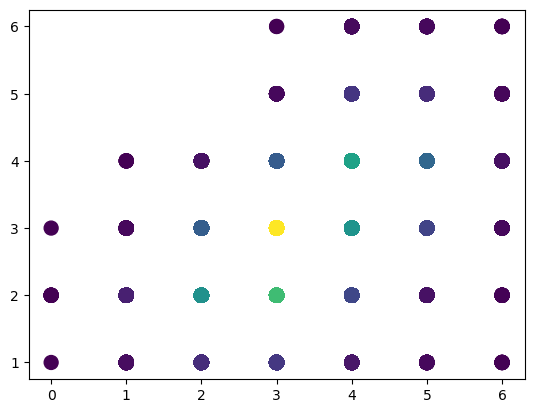

In [43]:
# density scatter plot 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x = train_data['critical']
y = train_data['score']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)

plt.show()


C:\Users\LiangX\AppData\Local\Temp\ipykernel_38476\904812044.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap="Blues", shade=True, bw_adjust=0.5)
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


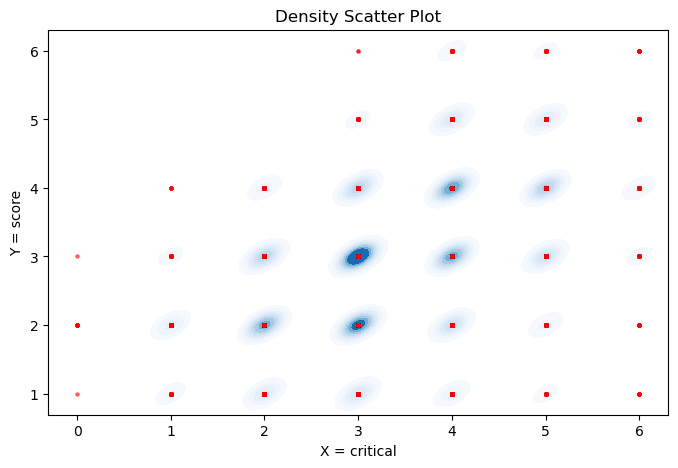

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

x = train_data['critical']
y = train_data['score']

# Plotting
plt.figure(figsize=(8, 5))
sns.kdeplot(x=x, y=y, cmap="Blues", shade=True, bw_adjust=0.5)
plt.scatter(x, y, s=5, color='red', alpha=0.5)
plt.title('Density Scatter Plot')
plt.xlabel('X = critical')
plt.ylabel('Y = score')
plt.show()


#### appropriate evidents

In [60]:
# import spacy

# # Load the installed model
# nlp = spacy.load('en_core_web_sm')

# # Test the model
# doc = nlp("This is a test sentence.")
# for token in doc:
#     print(token.text, token.pos_, token.dep_)


In [64]:
# # NER approach: Named Entity Recognition
# import pandas as pd
# import spacy

# # Load the spaCy model (make sure to install it first: `python -m spacy download en_core_web_sm`)
# nlp = spacy.load('en_core_web_sm')

# # Example DataFrame with cleaned text
# data = {
#     'cleaned_text': [
#         "According to a recent study, climate change is causing more frequent and severe weather events.",
#         "For example, the heatwaves in Europe last summer were attributed to climate change.",
#         "The report from the Intergovernmental Panel on Climate Change (IPCC) provides evidence of rising sea levels."
#     ]
# }

# df = pd.DataFrame(data)

# # Initialize a list to store counts
# counts = []

# # Process each document in the DataFrame
# for text in df['cleaned_text']:
#     doc = nlp(text)
#     example_count = 0

#     # Iterate over sentences in the document
#     for sentence in doc.sents:
#         # Perform named entity recognition (NER)
#         # for ent in sentence.ents:
#             # Example: Counting 'studies', 'reports', or specific entities like 'IPCC'
#             # if ent.label_ in ['ORG', 'PERSON', 'NORP']:  # Adjust labels based on your requirements
#             #     example_count += 1
#         example_count += len(sentence.ents)
    
#     counts.append(example_count)

# # Add a new column to DataFrame with the counts
# df['example_evidence_count'] = counts

# # Display the updated DataFrame
# print(df)


In [62]:
# NER approach: Named Entity Recognition
import pandas as pd
import spacy

# Load the spaCy model (make sure to install it first: `python -m spacy download en_core_web_sm`)
nlp = spacy.load('en_core_web_sm')

def examples_count(text):
    doc = nlp(text)
    example_count = 0
    # Iterate over sentences in the document
    for sentence in doc.sents:
        # Perform named entity recognition (NER)
        for ent in sentence.ents:
            # Example: Counting 'studies', 'reports', or specific entities like 'IPCC'
            if ent.label_ in ["CARDINAL", 
                                "DATE",  "EVENT",  "FAC", 
                                "GPE",  "LANGUAGE", "LAW", 
                                "LOC", "MONEY", "NORP", 
                                "ORDINAL", "ORG", "PERCENT", 
                                "PERSON", "PRODUCT", "QUANTITY", 
                                "TIME", "WORK_OF_ART","LOC", 
                                "MISC", "ORG", "PER"]:  # Adjust labels based on your requirements
                example_count += 1
            # example_count += len(sentence.ents)
    return example_count
    
examples_count("""Dear State senator , You should keep the electoral college , beacuse For one theres alot of electors 
like around 538. A majority of 270 electoral votes is required to elect the president. Then after the presidental election ,
your governor prepares a 'Certificate of Ascertainment ' listing all of the candidates who ran for president in your state 
along with the names of their respective electors.To begin with under the 23rd amendment of the constitution ,The District of 
Columbia is allocated 3 electors and treated like a state for purposes of the electoral college and for that saying , 
in the  following discussion , the  word state also refers to the district of columbia. Also Each and every candidate that is 
running for president in your state has his or her own group of electors.The electors are generally chosen by the candidate's political party , 
but state laws vary on how the electors are selected and what their responsibilities are.Foremost , under the electoral college system , 
voters vote not for the persident , but for a slate of electors , who in turn elect the president.
Who are the electors? They can be anyone not holding public office. Who picks the electors in the  first place? it depends on the state. 
Now i understand sometimes at state conventions , Partys , central committee , sometimes the presidental candidates themselves , 
Also sometimes get confused about the electors and vote for the wrong candidate.The single best argument against the electoral college is 
what we might call the electoral college is what we might call the  disaster factor. Its Basically whenever theres a  really good argument thats what its called.Subconstantquintly , 
Sometimes most people worry about the prospect of a tie in the elections vote. In That case , the election would be thrown to the house of representatives , 
where state delegations vote on the president. At the most basic level , the electoral college is unfair to voters. because of the winner-take-all system in each state ,
candidates dont spend time in states they know they have no chance of winning , focusing only on the tight races in the swing states. Then now its official  The electoral college is unfair , 
outdated , and irrational. The best arguments in favor of it in favor of it are mostly assertions without much basis in reality.To end with , Thats why you should keep the electoral college because ,  
You should keep the electoral college , beacuse For one theres alot of electors like around 538. A majority of 270 electoral votes is required to elect the president. 
Then after the presidental election , your governor prepares a 'Certificate of Ascertainment ' listing all of the candidates who ran for president in your state along with the names of their respective electors.  """)



14

##### Generate a new column to store it

In [63]:
train_data['examples'] = train_data['full_text'].apply(lambda x:examples_count(x))
train_data.head(10)

,essay_id,full_text,score,critical,examples
0,000d118,Many people have car where they live. The thin...,3,5,27
1,000fe60,I am a scientist at NASA that is discussing th...,3,4,12
2,001ab80,People always wish they had the same technolog...,4,4,2
3,001bdc0,"We all heard about Venus, the planet without a...",4,5,29
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,3,22
5,0030e86,If I were to choose between keeping the electo...,4,2,17
6,0033037,The posibilty of a face reconizing computer wo...,2,1,0
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,4,16
8,0036253,The challenge of exploring Venus\n\nThis stori...,2,3,10
9,0040e27,There are many reasons why you should join sea...,3,3,17


##### visualize the relationships 

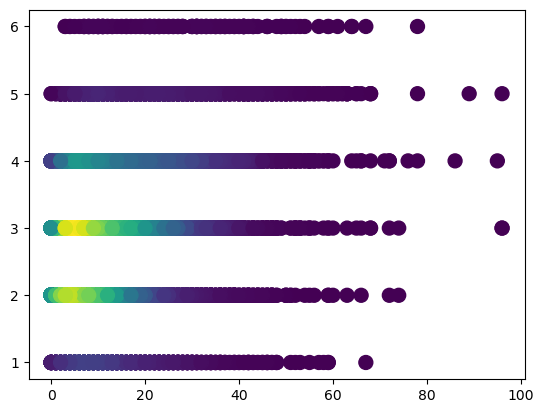

In [65]:
# density scatter plot 
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x = train_data['examples']
y = train_data['score']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)

plt.show()


C:\Users\LiangX\AppData\Local\Temp\ipykernel_38476\2015272120.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap="Blues", shade=True, bw_adjust=0.5)
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LiangX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


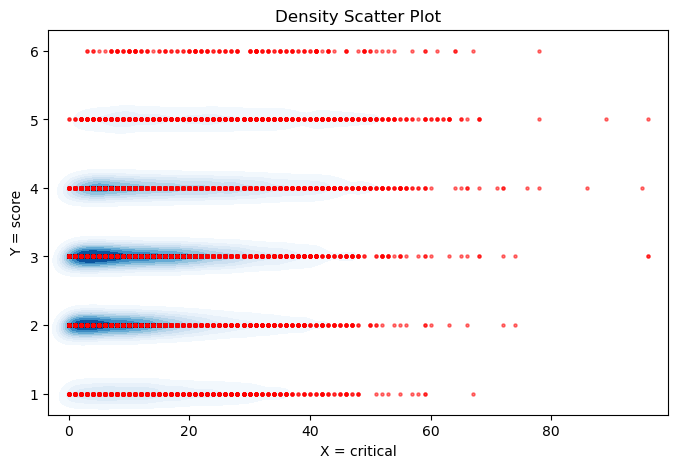

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

x = train_data['examples']
y = train_data['score']

# Plotting
plt.figure(figsize=(8, 5))
sns.kdeplot(x=x, y=y, cmap="Blues", shade=True, bw_adjust=0.5)
plt.scatter(x, y, s=5, color='red', alpha=0.5)
plt.title('Density Scatter Plot')
plt.xlabel('X = examples')
plt.ylabel('Y = score')
plt.show()


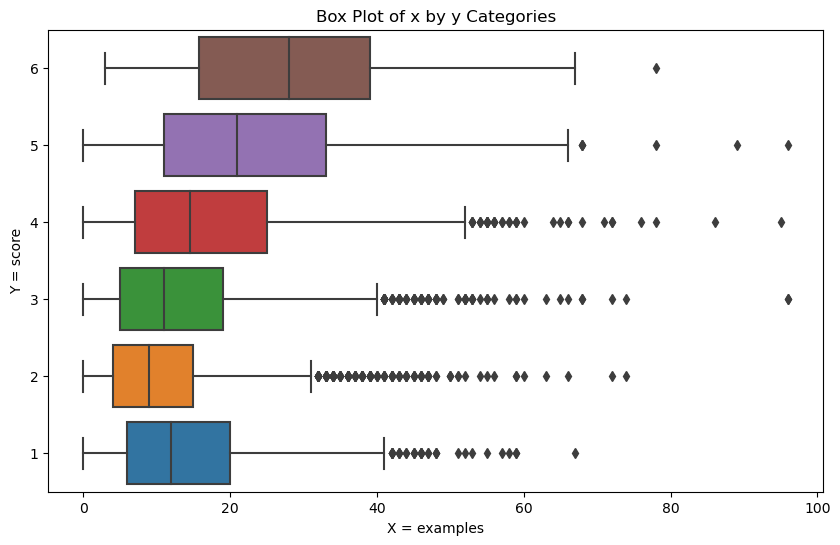

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

x = train_data['examples']
y = train_data['score']

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x=x, y=y, data=df, orient='h').invert_yaxis()
plt.title('Box Plot of x by y Categories')
plt.xlabel('X = examples')
plt.ylabel('Y = score')
plt.show()

#### language mastery (feedback dataset)

In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LiangX\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [79]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Attention


In [81]:
# import tensorflow_addons as tfa

In [82]:
train = pd.read_csv(".//feedback-prize-english-language-learning//train.csv")
train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [83]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [84]:
train['full_text'] = train['full_text'].apply(lambda x:clean_text(x))
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,i think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,when a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,dear principalif u change the school policy of...,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,the best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [85]:
def remove_stopword(text):
    if pd.notnull(text):
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        filtered_text = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_text)
    return text

In [86]:
train['full_text'] = train['full_text'].apply(lambda x:remove_stopword(x))
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,think students would benefit learning homebeca...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,problem change let best matter happening chang...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,dear principalif u change school policy grade ...,3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,best time life become agree greatest accomplis...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,small act kindness impact people change people...,2.5,3.0,3.0,3.0,2.5,2.5


In [88]:
train.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [89]:
train_essays, val_essays, train_scores, val_scores = train_test_split(train['full_text'],
                                                                      train[['cohesion', 'syntax', 'vocabulary',
                                                                                  'phraseology', 'grammar', 'conventions']],
                                                                      test_size=0.1,
                                                                      random_state=42)

In [90]:
# Train Word2Vec model
embedding_dim = 100
word2vec_model = Word2Vec(sentences=train_essays, vector_size=embedding_dim, min_count=1)

# Convert essays to word embeddings
train_embeddings = [np.mean([word2vec_model.wv[word] for word in essay], axis=0) for essay in train_essays]
val_embeddings = [np.mean([word2vec_model.wv[word] for word in essay], axis=0) for essay in val_essays]


In [91]:
len(train_embeddings)

3519

In [111]:
train_embeddings[0]

array([-0.0891779 ,  0.04064397,  0.02083636, -0.00455713, -0.05013455,
        0.02594292,  0.02954273,  0.08905659,  0.01901867, -0.10885919,
       -0.06712686, -0.02394208,  0.02900502, -0.02143904,  0.06878881,
        0.00199182,  0.06068218, -0.05721425,  0.02320529, -0.05709738,
       -0.01912576,  0.02541563,  0.05549537,  0.05707905, -0.10263152,
        0.11977784, -0.13058011, -0.02113626,  0.06478173,  0.12516366,
        0.09968751, -0.06937893, -0.01464949, -0.06061969, -0.0561918 ,
        0.06140374,  0.00801614, -0.00762232, -0.0590849 ,  0.00615895,
        0.11064301,  0.02710875, -0.05042378,  0.07819305, -0.07008065,
       -0.10729907,  0.04796978, -0.06896045, -0.01749361,  0.00242548,
        0.07071761, -0.07595003, -0.08811742,  0.03186933, -0.04157984,
        0.08907894,  0.04016543,  0.01508822,  0.03613447, -0.07068469,
       -0.03065689, -0.03233445,  0.130663  ,  0.03962409, -0.01384331,
        0.08456678,  0.01911041, -0.06718393, -0.07251865,  0.00

In [92]:
len(word2vec_model.wv.key_to_index)

27

In [93]:
vocabulary_size = len(word2vec_model.wv.key_to_index)
print("Vocabulary Size:", vocabulary_size)

# Check word embeddings shape
embedding_shape = word2vec_model.wv.vectors.shape
print("Embedding Shape:", embedding_shape)

Vocabulary Size: 27
Embedding Shape: (27, 100)


In [126]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, dot
# # Prepare the deep learning model
# input_dim = len(train_embeddings[0])
# inputs = Input(shape=(input_dim,))
# embedding_layer = Embedding(input_dim=vocabulary_size ,
#                             output_dim=embedding_dim,
#                             weights=[word2vec_model.wv.vectors],
#                             input_length=input_dim,
#                             trainable=False)(inputs)
# lstm_layer = LSTM(units=128, return_sequences=True)(embedding_layer)

# # Custom Attention Layer
# attention_weights = dot([lstm_layer, lstm_layer], axes=[2, 2])
# attention_weights = Dense(units=input_dim, activation='softmax')(attention_weights)
# context_vector = dot([attention_weights, lstm_layer], axes=[2, 1])
# attention_output = LSTM(units=128)(context_vector)

# output_layer = Dense(units=6, activation='linear')(attention_output)

# model = Model(inputs=inputs, outputs=output_layer)
# model.compile(optimizer='adam', loss='mean_squared_error')

In [114]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, dot, Flatten, Activation, RepeatVector, Permute, Multiply, Lambda
# import tensorflow.keras.backend as K

# # Prepare the deep learning model
# input_dim = len(train_embeddings[0])  # Assume this is the maximum sequence length
# vocabulary_size = len(word2vec_model.wv.vectors)  # Size of the vocabulary
# embedding_dim = word2vec_model.vector_size  # Dimension of word embeddings

# inputs = Input(shape=(input_dim,))
# embedding_layer = Embedding(input_dim=vocabulary_size,
#                             output_dim=embedding_dim,
#                             weights=[word2vec_model.wv.vectors],
#                             input_length=input_dim,
#                             trainable=False)(inputs)

# lstm_layer = LSTM(units=128, return_sequences=True)(embedding_layer)

# # Custom Attention Layer
# attention_weights = Dense(units=1, activation='tanh')(lstm_layer)
# attention_weights = Flatten()(attention_weights)
# attention_weights = Activation('softmax')(attention_weights)
# attention_weights = RepeatVector(128)(attention_weights)
# attention_weights = Permute([2, 1])(attention_weights)

# context_vector = Multiply()([lstm_layer, attention_weights])
# context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)

# # Directly use the context vector for Dense layer
# output_layer = Dense(units=6, activation='linear')(context_vector)

# model = Model(inputs=inputs, outputs=output_layer)
# model.compile(optimizer='adam', loss='mean_squared_error')


In [127]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Dot, Activation, Permute, Lambda
import tensorflow.keras.backend as K

# Define maximum sequence length and vocabulary size
max_seq_length = 100  # Adjust according to your data
vocabulary_size = len(word2vec_model.wv.vectors)
embedding_dim = word2vec_model.vector_size

# Input for text data
inputs = Input(shape=(max_seq_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocabulary_size,
                            output_dim=embedding_dim,
                            weights=[word2vec_model.wv.vectors],
                            input_length=max_seq_length,
                            trainable=False)(inputs)

# LSTM layer
lstm_layer = LSTM(units=128, return_sequences=True)(embedding_layer)

# Attention mechanism
attention = Dense(1, activation='tanh')(lstm_layer)
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention)
attention = Dot(axes=[2, 1])([attention, lstm_layer])

# LSTM layer after attention
lstm_output = LSTM(units=128)(attention)

# Output layer
output = Dense(6, activation='linear')(lstm_output)

# Model definition
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\LiangX\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# !pip install tensorflow-addons

In [ ]:
# import tensorflow_addons as tfa

In [128]:
# Train the model
model.fit(np.array(train_embeddings), np.array(train_scores), epochs=15, validation_data=(np.array(val_embeddings), np.array(val_scores)))

Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 3.1289 - val_loss: 0.4361
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.4311 - val_loss: 0.4266
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.4290 - val_loss: 0.4278
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.4335 - val_loss: 0.4370
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.4249 - val_loss: 0.4300
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.4378 - val_loss: 0.4271
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.4444 - val_loss: 0.4472
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.4266 - val_loss: 0.4273
Epoch 9/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.4178 - val_loss: 0.4294
Epoch 10/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.4311 - val_loss: 0.4307
Epoch 11/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.4262 - val_loss: 0.4279
Epoch 12/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 

In [116]:
# data processing before prediction
train_data['full_text'] = train_data['full_text'].apply(lambda x:clean_text(x))
train_data['full_text'] = train_data['full_text'].apply(lambda x:remove_stopword(x))
train_data.head()

,essay_id,full_text,score,critical,examples
0,000d118,many people car live thing dont know use car a...,3,5,27
1,000fe60,scientist nasa discussing face mars explaining...,3,4,12
2,001ab80,people always wish technology seen movies best...,4,4,2
3,001bdc0,heard venus planet without almost oxygen earth...,4,5,29
4,002ba53,dear state senatorthis letter argue favor keep...,3,3,22


In [117]:
data_embeddings = [np.mean([word2vec_model.wv[word] for word in essay if word in word2vec_model.wv],
                           axis=0) for essay in train_data['full_text']]

# Predict scores for test data
predicted_scores = model.predict(np.array(data_embeddings))

541/541 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


In [129]:
# Train Word2Vec model
embedding_dim = 100
word2vec_model = Word2Vec(sentences=train_data['full_text'], vector_size=embedding_dim, min_count=1)

# Convert essays to word embeddings
data_embeddings = [np.mean([word2vec_model.wv[word] for word in essay], axis=0) for essay in train_data['full_text']]

In [130]:
len(data_embeddings)

17307

In [131]:
# Predict scores for test data
predicted_scores = model.predict(np.array(data_embeddings))

541/541 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step


In [132]:
# Create new dataset
new_df = pd.DataFrame(predicted_scores, columns=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])
new_df.insert(0, 'full_text', train_data['full_text'])

new_df.head()

,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,many people car live thing dont know use car a...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772
1,scientist nasa discussing face mars explaining...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772
2,people always wish technology seen movies best...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772
3,heard venus planet without almost oxygen earth...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772
4,dear state senatorthis letter argue favor keep...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772


In [133]:
new_df.tail()

,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
17302,story challenge exploing venus informative pie...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772
17303,technology changed lot ways live today nowaday...,3.067335,2.984078,3.230933,3.119638,2.973856,3.044772
17304,dont like sitting around day great opportunity...,3.067335,2.984078,3.230933,3.119638,2.973857,3.044773
17305,challenge exporing venus author suggests study...,3.067335,2.984078,3.230933,3.119638,2.973857,3.044773
17306,venus worthy place study dangerous reaosn thei...,3.067335,2.984078,3.230933,3.119638,2.973857,3.044773


In [ ]:
# use this model to do prediction on each essay of current dataset


### LSTM

In [10]:
train_data.head(10)

,essay_id,full_text,score
0,000d118,many people car live thing dont know use car a...,3
1,000fe60,scientist nasa discussing face mars explaining...,3
2,001ab80,people always wish technology seen movies best...,4
3,001bdc0,heard venus planet without almost oxygen earth...,4
4,002ba53,dear state senatorthis letter argue favor keep...,3
5,0030e86,choose keeping electoral college abolishing wo...,4
6,0033037,posibilty face reconizing computer would helpf...,2
7,0033bf4,seagoing cowboys progamit help many countries ...,3
8,0036253,challenge exploring venusthis storie challeng ...,2
9,0040e27,many reasons join seagoing cowboys program wou...,3


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
train_essays, val_essays, train_scores, val_scores = train_test_split(train_data['full_text'],
                                                                      train_data['score'],
                                                                      test_size=0.2,
                                                                      random_state=42)

In [15]:
features = 5000 #number of words in dictionary
tokenizer = tokenizer = Tokenizer(num_words = features, oov_token='<OOV>') #OOV is for words not in the dictionary
tokenizer.fit_on_texts(train_essays)
word_index = tokenizer.word_index

train_essays = tokenizer.texts_to_sequences(list(train_essays))
val_essays   = tokenizer.texts_to_sequences(list(val_essays))

In [63]:
max_length = 2000 #Max words in the news sequence

x_train_padded = pad_sequences(train_essays, maxlen=max_length, padding='post', truncating='post')
x_val_padded   = pad_sequences(val_essays,   maxlen=max_length, padding='post', truncating='post')

In [64]:
label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(train_data['score'])

train_scores = np.array(train_scores)
val_scores   = np.array(val_scores)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
import tensorflow as tf
print('Tensorflow:',tf.__version__)

Tensorflow: 2.16.1


In [68]:
embedding_dim = 64
num_classes = 6

LSTM_model = Sequential()
LSTM_model.add(Embedding(features,embedding_dim)) #Vocabulary size, Embedding
LSTM_model.add(Dropout(0.5))
LSTM_model.add(Bidirectional(LSTM(embedding_dim)))
LSTM_model.add(Dense(num_classes, activation = 'softmax'))

# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 386,822
Trainable params: 386,822
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Train the model
history = LSTM_model.fit(x_train_padded, train_scores, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
347/347 [==============================] - 928s 3s/step - loss: 8.8839 - mean_absolute_error: 2.7924 - val_loss: 8.7460 - val_mean_absolute_error: 2.7654
Epoch 2/10
347/347 [==============================] - 935s 3s/step - loss: 8.8839 - mean_absolute_error: 2.7924 - val_loss: 8.7460 - val_mean_absolute_error: 2.7654
Epoch 3/10
347/347 [==============================] - 952s 3s/step - loss: 8.8839 - mean_absolute_error: 2.7924 - val_loss: 8.7460 - val_mean_absolute_error: 2.7654
Epoch 4/10
193/347 [===============>..............] - ETA: 14:15 - loss: 8.8857 - mean_absolute_error: 2.7951

KeyboardInterrupt: 

In [17]:
# code from ChatGPT

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split


# Split data into training and validation sets
train_essays, val_essays, train_scores, val_scores = train_test_split(
    train_data['full_text'],
    train_data['score'],
    test_size=0.2,
    random_state=42
)

# Tokenizing the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_essays)
train_sequences = tokenizer.texts_to_sequences(train_essays)
val_sequences = tokenizer.texts_to_sequences(val_essays)

# Padding sequences to ensure they have the same length
max_len = max(len(seq) for seq in train_sequences)
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_val = pad_sequences(val_sequences, maxlen=max_len)

# Converting scores to numpy arrays
y_train = np.array(train_scores)
y_val = np.array(val_scores)

#############################################################################################
# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='linear'))  # Use 'linear' activation for regression
#############################################################################################
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print(f'Mean Absolute Error on Validation Set: {mae}')




# Example new texts for prediction
new_texts = ["There are many reasons why you should join seagoing cowboys program. You would be helping your country. You'd be traveling around the world. Last you'd have lots of fun over seas. You'd be helping our country because when Luke was in seagoing cowboy program it was 1945 and world war 2 was happening in Europe and he had to those countries recover. Luke had to help the horses when the war was over to get people places and to work. If you were 18 or up you might be lucky and be drafted into the military service. The UNRRA would hire seagoing Cowboys to feed the horses cows and mules that were shipped overseas. You'd be traveling around they world like Luke did. It took Luke 2 weeks to cross the Atlantic Ocean from the eastern coast. You'd be traveling to China, Europe, Greece, and many more places. The only way you'd be good at this job is if you wouldn't get sea sick because if you are a seagoing cowboy told travel overseas a lot. You'd have fun overseas if you don't get seasick. You'd have many adventures. You'd have many stories to tell your friends and family. You'd been in countries you'd didn't think you'd be in. You'd be able to play games in the countries you visit in the seagoing Cowboys program. If you join the seagoing Cowboys program you'd love it. You'd be traveling. You'd be having fun. You'd be helping our country. So why don't you join our seagoing cowboy program. I bet you'd love to be in this program with all our helpful friends and family that want to try to help our country. ", 
             "the colleg now has votes for vice presidant and there are 538 electors but 270 electors are what we are suppos to have 3 were picked by the state they have a presadent election for evry for years if you run for president you get your own group and you get alot of responsibilities and it is held evry tuseday and first monday and the winner takes it all and they have other cannidates to worrie about and the govener prepares for the presidans election and there are about 60% of voters if your the presidant you need to defened your titel back in 1960's in lousiana we almost succeeded but then they hired other electors to go agianst John F Kennedy and then evrybody was faithlessand now their are 500,000 voters and it has increased drasticly and we half to make a congress if your presidant 35,000,000 go to just pick a presidant 41,971 are in deadlock  in 1976 there were about 5,559 elections back then there are 25,000 media markets texas hade the most voters in 1987 and all of are presadents have at least 2,000 or more canadates bush hade the least votes sence 1888 61.5% of votes was compared to a voteing persentage of 51.3% and that was in the north and south 2012 they have boosted their companie and their attinstion by ads and some build boards 29 elctoral votes 3 were passed through their were 301 votes now there are 370 votes and this all happened in 1992 and there are more dimacrats in texas than there are in florida there are 20 in florida and 33 in texas and all of the elections are nation wide and voters do half of the work for just voteing and the pepole are going through the votes to see hew there new presidant is for the new year and all the votes came from Electrol colleg and all of the campains are in the small states and in texas they have turned off votes in texas and now there is less attenstion in the compainey and they do politicl votes and the pepole think that the voters should be the ones to decid the election and up state voters pay close attention to see hew wins."]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_X = pad_sequences(new_sequences, maxlen=max_len)

# Predict scores
predictions = model.predict(new_X)
print(predictions)


Epoch 1/5


C:\Users\LiangX\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


433/433 ━━━━━━━━━━━━━━━━━━━━ 264s 606ms/step - loss: 1.9088 - mean_absolute_error: 1.0348 - val_loss: 0.6640 - val_mean_absolute_error: 0.6502
Epoch 2/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 259s 599ms/step - loss: 0.6833 - mean_absolute_error: 0.6526 - val_loss: 0.6237 - val_mean_absolute_error: 0.6190
Epoch 3/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 252s 582ms/step - loss: 0.3855 - mean_absolute_error: 0.4815 - val_loss: 0.5376 - val_mean_absolute_error: 0.5816
Epoch 4/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 265s 612ms/step - loss: 0.2487 - mean_absolute_error: 0.3853 - val_loss: 0.4997 - val_mean_absolute_error: 0.5595
Epoch 5/5
433/433 ━━━━━━━━━━━━━━━━━━━━ 249s 574ms/step - loss: 0.1654 - mean_absolute_error: 0.3102 - val_loss: 0.5067 - val_mean_absolute_error: 0.5601
Mean Absolute Error on Validation Set: 0.5601108074188232
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
[[2.9402397]
 [1.1603671]]
